# Optimization of Urban Waste Collection Routes Using Ant Colony Optimization (ACO)

Cycle 1/5
Cycle 2/5
Cycle 3/5
Cycle 4/5
Cycle 5/5
Cycle 1/5
Cycle 2/5
Cycle 3/5
Cycle 4/5
Cycle 5/5


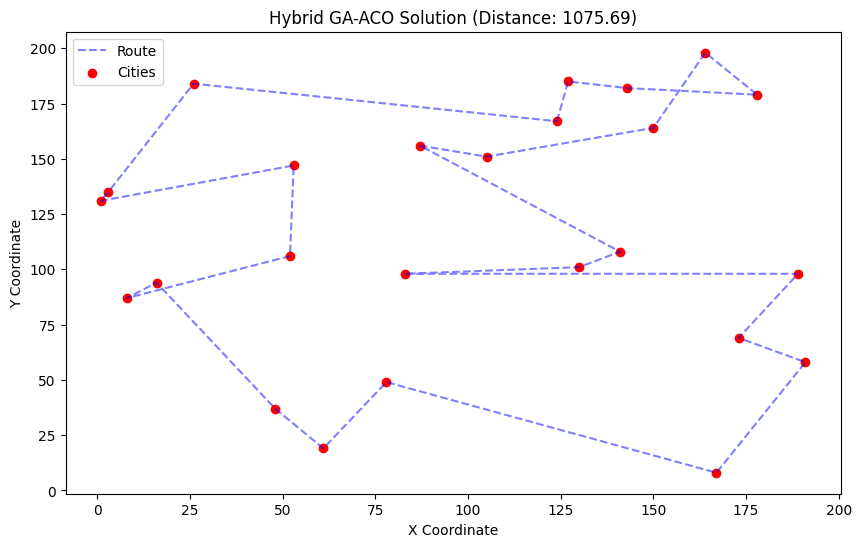

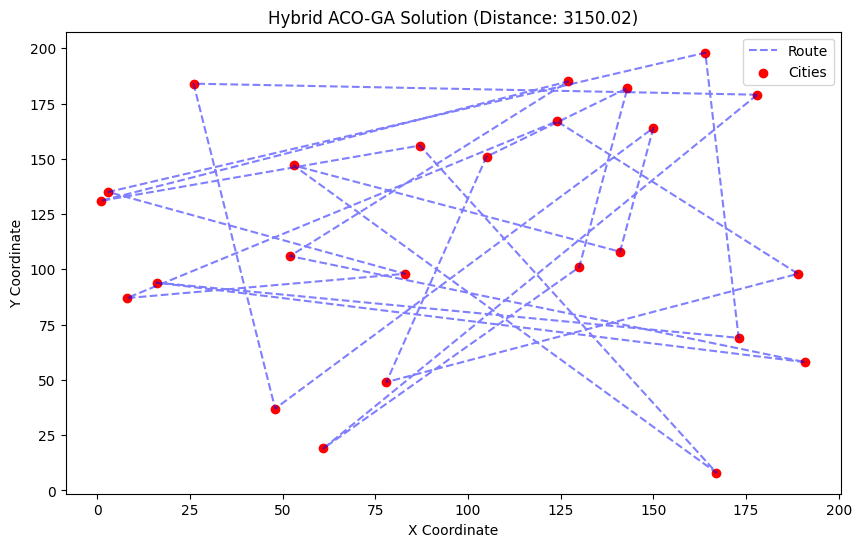

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt

class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, city):
        return np.sqrt((self.x - city.x)**2 + (self.y - city.y)**2)

# Genetic Algorithm Components
class GA:
    def __init__(self, cities, pop_size=50, mutation_rate=0.02):
        self.cities = cities
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.population = [ ]

    def create_individual(self):
        return random.sample(self.cities, len(self.cities))

    def rank_routes(self, population):
        fitness_results = {i: 1/self.route_distance(p) for i, p in enumerate(population)}
        return sorted(fitness_results.items(), key=lambda x: x[1], reverse=True)

    def selection(self, ranked_pop):
    # Select elites (top 50%)
        elites = [i for i, _ in ranked_pop[:self.pop_size//2]]
    
    # Select remaining 50% from non-elites (to avoid duplicates)
        non_elites = [i for i, _ in ranked_pop[self.pop_size//2:]]
        non_elite_weights = [f for _, f in ranked_pop[self.pop_size//2:]]
    
        remaining = random.choices(
            non_elites,
            weights=non_elite_weights,
            k=self.pop_size//2
        )
    
        return elites + remaining

    def crossover(self, parent1, parent2):
        child = []
        gene_a = random.randint(0, len(parent1)-1)
        gene_b = random.randint(0, len(parent1)-1)
        start, end = min(gene_a, gene_b), max(gene_a, gene_b)
        child += parent1[start:end+1]
        child += [city for city in parent2 if city not in child]
        return child

    def mutate(self, individual):
        for i in range(len(individual)):
            if random.random() < self.mutation_rate:
                j = random.randint(0, len(individual)-1)
                individual[i], individual[j] = individual[j], individual[i]
        return individual

    def route_distance(self, route):
        distance = 0
        for i in range(len(route)):
            distance += route[i].distance(route[(i+1)%len(route)])
        return distance
    def create_solution(self):
        self.population=[self.create_individual() for _ in range(50)]
        ranked = self.rank_routes(self.population)
        selection = self.selection(ranked)
        next_gen = []
        while len(next_gen) < self.pop_size:
            parent1, parent2 = random.choices(selection, k=2)
            child = self.crossover(self.population[parent1], 
                                            self.population[parent2])
            next_gen.append(self.mutate(child))
            population = next_gen
        ga_best = sorted(self.population, key=lambda x: self.route_distance(x),reverse=True)
        ga_best = ga_best[0]
        return ga_best


# Ant Colony Optimization Components
class ACO:
    def __init__(self, cities, n_ants=20, alpha=1, beta=2, evaporation=0.5):
        self.cities = cities
        self.n_ants = n_ants
        self.alpha = alpha
        self.beta = beta
        self.evaporation = evaporation
        self.pheromone = np.ones((len(cities), len(cities)))

    def construct_solution(self):
        best_route = None
        best_distance = float('inf')
        for _ in range(self.n_ants):
            route = self.ant_tour()
            distance = self.route_distance(route)
            if distance < best_distance:
                best_route = route
                best_distance = distance
            self.update_pheromones(route, distance)
        return best_route, best_distance

    def ant_tour(self):
        cities = self.cities.copy()
        route = []
        current = random.choice(cities)
        route.append(current)
        cities.remove(current)
        while cities:
            probabilities = self.calculate_probabilities(current, cities)
            next_city = random.choices(cities, weights=probabilities)[0]
            route.append(next_city)
            cities.remove(next_city)
            current = next_city
        return route

    def calculate_probabilities(self, current, cities):
        total = 0
        pheromones = []
        current_idx = self.cities.index(current)
        for city in cities:
            city_idx = self.cities.index(city)
            pheromone = self.pheromone[current_idx][city_idx] ** self.alpha
            heuristic = (1 / current.distance(city)) ** self.beta
            pheromones.append(pheromone * heuristic)
            total += pheromone * heuristic
        return [p/total for p in pheromones]

    def update_pheromones(self, route, distance):
        self.pheromone *= self.evaporation
        for i in range(len(route)):
            a = self.cities.index(route[i])
            b = self.cities.index(route[(i+1)%len(route)])
            self.pheromone[a][b] += 1/distance
            self.pheromone[b][a] += 1/distance

    def route_distance(self, route):
        distance = 0
        for i in range(len(route)):
            distance += route[i].distance(route[(i+1)%len(route)])
        return distance

# Hybrid GA-ACO System
class HybridGAACO:
    def __init__(self, cities):
        self.cities = cities
        self.ga = GA(cities)
        self.aco = ACO(cities)
        self.population = [self.ga.create_individual() for _ in range(50)]

    def run(self, ga_generations=20, aco_iterations=10, cycles=5):
        best_overall = None
        best_distance = float('inf')
        
        for cycle in range(cycles):
            print(f"Cycle {cycle+1}/{cycles}")
            
            # GA Phase
            for _ in range(ga_generations):
                ranked = self.ga.rank_routes(self.population)
                selection = self.ga.selection(ranked)
                next_gen = []
                while len(next_gen) < self.ga.pop_size:
                    parent1, parent2 = random.choices(selection, k=2)
                    child = self.ga.crossover(self.population[parent1], 
                                            self.population[parent2])
                    next_gen.append(self.ga.mutate(child))
                self.population = next_gen
            
            # Transfer to ACO
            ga_best =sorted(self.population, key=lambda x: self.ga.route_distance(x),reverse=True)
            ga_best= ga_best[:10]
            self.aco.pheromone = np.ones((len(self.cities), len(self.cities)))

            for citys in ga_best:
                for city in citys:
                    idx = self.cities.index(city)
                    self.aco.pheromone[idx] += 10  # Boost pheromones from GA solution
            
            # ACO Phase
            aco_best, aco_dist = self.aco.construct_solution()
            if aco_dist < best_distance:
                best_overall = aco_best
                best_distance = aco_dist
            
            # Transfer to GA
            self.population = [aco_best] + random.sample(
                self.population, len(self.population)-1)
        
        return best_overall, best_distance

###the run with aco first and then ga second
    def run_ga_aco(self, ga_generations=20, aco_iterations=10, cycles=5):
        best_overall = None
        best_distance = float('inf')
        next_gen = []
        for cycle in range(cycles):
            print(f"Cycle {cycle+1}/{cycles}")
            
            # ACO Phase
            for _ in range(aco_iterations):
                aco_best, aco_dist = self.aco.construct_solution()
                if aco_dist < best_distance:
                    best_overall = aco_best
                    best_distance = aco_dist
                self.aco.update_pheromones(aco_best, aco_dist)
                next_gen.append(aco_best)
            #transfer to ga
            self.population = next_gen + random.sample(
                self.population, len(self.population)-len(next_gen))
            #ga phase
            for _ in range(ga_generations):
                ranked = self.ga.rank_routes(self.population)
                selection = self.ga.selection(ranked)
                next_gen = []
                while len(next_gen) < self.ga.pop_size:
                    parent1, parent2 = random.choices(selection, k=2)
                    child = self.ga.crossover(self.population[parent1], 
                                            self.population[parent2])
                    next_gen.append(self.ga.mutate(child))
                self.population = next_gen
            best_overall = max(self.population, key=lambda x: self.ga.route_distance(x))
            best_distance = self.ga.route_distance(best_overall)
        return best_overall, best_distance



# Example usage
if __name__ == "__main__":
    # Create 25 random cities
    cities = [City(x=random.randint(0, 200), y=random.randint(0, 200)) for _ in range(25)]
    
    hybrid = HybridGAACO(cities)
    best_route, best_distance = hybrid.run()
    best_route2, best_distance2 = hybrid.run_ga_aco()

    # Plot results
    x = [city.x for city in best_route]
    y = [city.y for city in best_route]
    plt.figure(figsize=(10, 6))
    plt.plot(x + [x[0]], y + [y[0]], 'b--', alpha=0.5, label='Route')
    plt.scatter(x, y, c='red', label='Cities')
    plt.title(f'Hybrid GA-ACO Solution (Distance: {best_distance:.2f})')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()
    x = [city.x for city in best_route2]
    y = [city.y for city in best_route2]
    plt.figure(figsize=(10, 6))
    plt.plot(x + [x[0]], y + [y[0]], 'b--', alpha=0.5, label='Route')
    plt.scatter(x, y, c='red', label='Cities')
    plt.title(f'Hybrid ACO-GA Solution (Distance: {best_distance2:.2f})')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

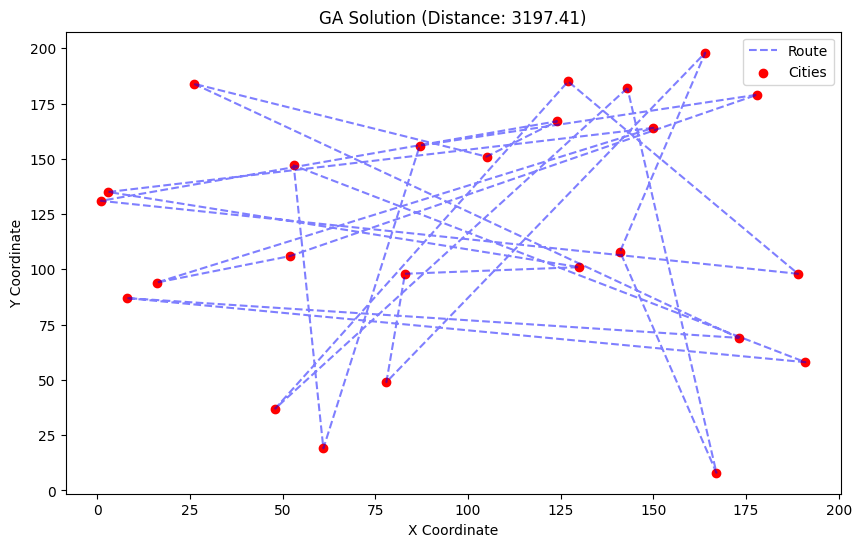

In [ ]:

GA_TEST= GA(cities)

BESTga=GA_TEST.create_solution()

distance= GA_TEST.route_distance(BESTga)

        



x= [city.x for city in BESTga]
y= [city.y for city in BESTga]
plt.figure(figsize=(10, 6))
plt.plot(x + [x[0]], y + [y[0]], 'b--', alpha=0.5, label='Route')
plt.scatter(x, y, c='red', label='Cities')
plt.title(f'GA Solution (Distance: {distance:.2f})')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()

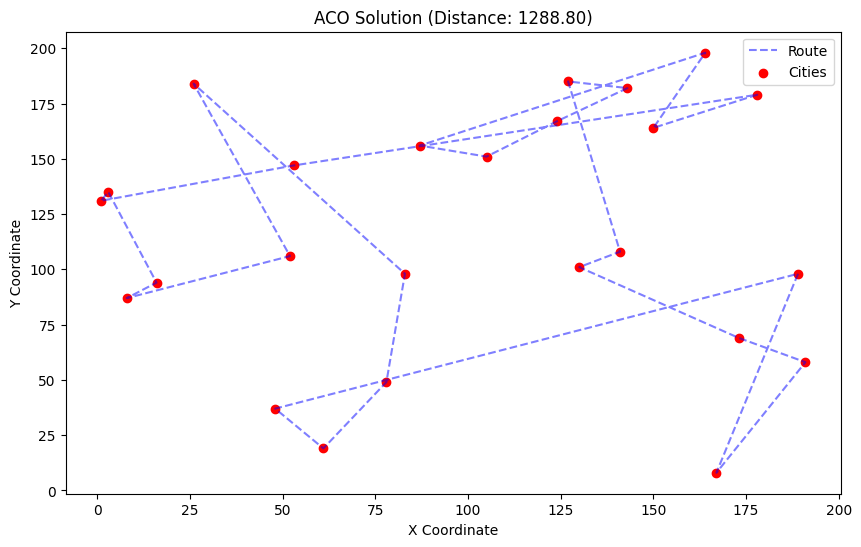

In [12]:

ACO_TEST= ACO(cities)

BESTACO,ACO_distance=ACO_TEST.construct_solution()


        



x= [city.x for city in BESTACO]
y= [city.y for city in BESTACO]
plt.figure(figsize=(10, 6))
plt.plot(x + [x[0]], y + [y[0]], 'b--', alpha=0.5, label='Route')
plt.scatter(x, y, c='red', label='Cities')
plt.title(f'ACO Solution (Distance: {ACO_distance:.2f})')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()